Utility notebook to skim candidates

# Import

In [1]:
import sys, os, pickle, time
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
from multiprocessing import Pool

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist

from progressBar import ProgressBar
from categoriesDef import categories
from B02JpsiKst_selection import candidate_selection, trigger_selection, candidateSelection_stringList, candidateSelection_nameList

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1


CMS_lumi.extraText = "     Simulation Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


# Create histograms file

In [3]:
file_loc = {}

In [4]:
MCdataSet = {
'n_PU20' : DSetLoader('B0_JpsiKst_PU20', candDir='ntuples_B2JpsiKst'),
'FSR_PU20' : DSetLoader('B0_JpsiKstFSR_PU20', candDir='ntuples_B2JpsiKst'),
}
for n, d in MCdataSet.iteritems():
    file_loc[n] = os.path.join(d.ntuples_dir, 'out_CAND_*.root')

In [5]:
# RDloc = '../data/cmsRD/ParkingBPH*/'
# file_loc['dataB2DstMu'] = RDloc+'*2018*B2JpsiKst_200124_CAND.root'

In [6]:
def makeSelection(inputs):
    tag, filepath, leafs_names, cat, idxInt, skipCut, serial = inputs
    N_accepted_cand = []
    N_accepted_tot = 0
    
    tree = rt.TChain('outA/Tevts')
    lastIdxDisc = -1
    for fn in glob(filepath):
        tree.Add(fn)
        if tree.GetEntries() + lastIdxDisc < idxInt[0]:
            lastIdxDisc += tree.GetEntries()
            tree = rt.TChain('outA/Tevts')
        elif tree.GetEntries() + lastIdxDisc > idxInt[1]:
            break
    
    nDiscEvts = lastIdxDisc + 1
            
        
    if serial:
#         print 'Tot evts:', idxInt[1]+1
        pb = ProgressBar(maxEntry=idxInt[1]+1)
    else:
        perc = int((idxInt[1]-idxInt[0])*0.3)
    
    output = np.zeros((int(1.5*(idxInt[1]-idxInt[0]+1)), len(leafs_names)))
    for i_ev, ev in enumerate(tree):
        i_ev += nDiscEvts
        if i_ev < idxInt[0]:
            continue
        if i_ev > idxInt[1]:
            break
            
        if serial:
#             print 'ev:', i_ev
            pb.show(i_ev-idxInt[0])
        elif (i_ev-idxInt[0]) % perc == 0:
            print tag, ': {:.0f}%'.format(100*(i_ev+1-idxInt[0])/(idxInt[1]-idxInt[0]))
        N_acc = 0
        
        idxTrg = -1
        trgMu_pt = -1
        N_trgMu = 0
        for j in range(ev.trgMu_pt.size()):
            if trigger_selection(j, ev, cat):
                N_trgMu += 1
                if ev.trgMu_pt[j] > trgMu_pt:
                    trgMu_pt = ev.trgMu_pt[j]
                    idxTrg = j
        if N_trgMu == 0:
            continue

        for j in range(ev.pval_piK.size()):
            if not skipCut == 'all':
                if not candidate_selection(j, ev, skipCut):
                    continue

            N_acc += 1

            aux = (ev.trgMu_pt[idxTrg], ev.trgMu_eta[idxTrg], ev.trgMu_sigdxy[idxTrg],
                   ev.mum_pt[j], ev.mum_eta[j], ev.mum_dxy[j],
                   ev.mup_pt[j], ev.mup_eta[j], ev.mup_dxy[j],
                   ev.pval_mumu[j], ev.mass_mumu[j],
                   ev.Jpsi_pt[j], ev.cosT_Jpsi_PV[j],
                   ev.K_pt[j], ev.K_sigdxy_PV[j],
                   ev.pi_pt[j], ev.pi_sigdxy_PV[j],
                   ev.pval_piK[j], ev.mass_piK[j], ev.mass_piK_CPconj[j], ev.mass_KK[j],
                   ev.sigdxy_vtxKst_PV[j],
                   ev.pval_mumupiK[j], ev.mass_mumupiK[j],
                   ev.B_mumupiK_pt[j], ev.B_mumupiK_eta[j],
                   trigger_selection(idxTrg, ev, categories['low']),
                   trigger_selection(idxTrg, ev, categories['mid']),
                   trigger_selection(idxTrg, ev, categories['high']),
                   ev.N_vertexes
                  )
            if not 'data' in n:
                aux += (ev.MC_B_pt, ev.MC_B_eta,
                        ev.MC_idxCand == j,
                        ev.MC_mup_pt, ev.MC_mup_eta,
                        ev.MC_mum_pt, ev.MC_mum_eta
                        )
        
            output[N_accepted_tot] = aux
            N_accepted_tot += 1

        if N_acc > 0:
            N_accepted_cand.append(N_acc)

    output = output[:N_accepted_tot]
    if not serial:
        print tag, ': done'
    return [output, N_accepted_cand]

In [7]:
def create_dSet(n, filepath, cat, skipCut=None, maxEntries=1e15):  
    catName = cat.name
    print n, catName
    if 'data' in n:
        loc = '../data/cmsRD/skimmed/B2JpsiKst_' + filepath[-16:-10]
        fskimmed_name = loc + '_' + catName 
        if not skipCut is None:
            fskimmed_name += '_skip'+str(skipCut)
        fskimmed_name += '.root'
        N_evts_per_job = 1000000
    else:
        d = os.path.dirname(filepath) + '/skimmed/'
        if not os.path.isdir(d):
            os.makedirs(d)
        fskimmed_name = d + catName 
        if not skipCut is None:
            fskimmed_name += '_skip'+str(skipCut)
        fskimmed_name += '.root'
        N_evts_per_job = 50000
    logfile = fskimmed_name.replace('.root', '.log')
    if os.path.isfile(fskimmed_name) and not n in recreate:
        print 'Already present'
    else:
        tree = rt.TChain('outA/Tevts')
        for fn in glob(filepath):
            tree.Add(fn)
        N_cand_in = min(maxEntries, tree.GetEntries())
        print n, ': Total number of candidate events =', N_cand_in
            
        leafs_names = [ 'trgMu_pt', 'trgMu_eta', 'trgMu_sigdxy',
                        'mum_pt', 'mum_eta', 'mum_dxy',
                        'mup_pt', 'mup_eta', 'mup_dxy',
                        'pval_mumu', 'mass_mumu',
                        'Jpsi_pt', 'cosT_Jpsi_PV',
                        'K_pt', 'K_sigdxy_PV',
                        'pi_pt', 'pi_sigdxy_PV',
                        'pval_piK', 'mass_piK', 'mass_piK_CPconj', 'mass_KK',
                        'sigdxy_vtxKst_PV',
                        'pval_mumupiK', 'mass_mumupiK',
                        'B_pt', 'B_eta',
                        'cat_low', 'cat_mid', 'cat_high',
                        'N_vtx'
                      ]
        if not 'data' in n:
            leafs_names += ['MC_B_pt', 'MC_B_eta',
                            'MCidxCandMatch',
                            'MC_mup_pt', 'MC_mup_eta',
                            'MC_mum_pt', 'MC_mum_eta'
                           ]
            
        if N_cand_in < 2*N_evts_per_job:
            output, N_accepted_cand = makeSelection(['', filepath, leafs_names, cat, 
                                                     [0, N_cand_in-1], skipCut, True])
        else:
            pdiv = list(np.arange(0, N_cand_in, N_evts_per_job))
            if not pdiv[-1] == N_cand_in: 
                pdiv.append(N_cand_in)
            print 'Will be divided into ' + str(len(pdiv)-1) + ' jobs'
            inputs = []
            for i in range(1, len(pdiv)):
                corr = 0
                if i == 1:
                    corr = -1
                inputs.append([str(i), filepath, leafs_names, cat, [pdiv[i-1]+1+corr, pdiv[i]], skipCut, False])
            print ' '
            
            start = time.time()
            p = Pool(min(25,len(inputs)))
            outputs = p.map(makeSelection, inputs)
            output = np.concatenate(tuple([o[0] for o in outputs]))
            N_accepted_cand = []
            for o in outputs: N_accepted_cand += o[1]
            print 'Total time: {:.1f} min'.format((time.time()-start)/60.)
                
        
        dset = pd.DataFrame(output, columns=leafs_names)
        if not os.path.isdir(os.path.dirname(fskimmed_name)):
            os.makedirs(os.path.dirname(fskimmed_name))
        rtnp.array2root(dset.to_records(), fskimmed_name, treename='Tevts', mode='RECREATE')
        
        with open(logfile, 'w') as f:
            ln = 'Number of candidates per events\n{'
            ln += ', '.join(['{}:{}'.format(i, N_accepted_cand.count(i)) for i in range(1, np.max(N_accepted_cand)+1)])
            ln += '}\n'
            f.write(ln)
            f.write('N_analyzed: '+str(N_cand_in)+'\n')
            f.write('N_accepted: '+str(dset.shape[0])+'\n')
            e = getEff(dset.shape[0], N_cand_in)
            f.write('Eff: {:.3f} +/- {:.3f} %'.format(1e2*e[0], 1e2*e[1])+'\n')
         
    os.system('echo '+logfile+';cat '+logfile + ';echo ')

In [8]:
from categoriesDef import categories

recreate = file_loc.keys()

# for n, fp in file_loc.iteritems():
#     create_dSet(n, fp, categories['high'], 'all')

# for n, fp in file_loc.iteritems():
#         create_dSet(n, fp, categories['high'])

for cn in ['low', 'mid', 'high']:
    for n, fp in file_loc.iteritems():
        create_dSet(n, fp, categories[cn])

n_PU20 Low
n_PU20 : Total number of candidate events = 861137
Will be divided into 18 jobs
 
1 : 0%
7 : 0%
6 : 0%
5 : 0%
9 : 0%
3 : 0%
2 : 0%
12 : 0%
4 : 0%
11 : 0%
13 : 0%
14 : 0%
8 : 0%
10 : 0%
16 : 0%
15 : 0%
18 : 0%
17 : 0%
18 : 30%
18 : 59%
9 : 30%
18 : 89%
18 : done
15 : 30%
5 : 30%
12 : 30%
2 : 30%
3 : 30%
13 : 30%
1 : 30%
6 : 30%
10 : 30%
4 : 30%
7 : 30%
8 : 30%
16 : 30%
17 : 30%
14 : 30%
11 : 30%
13 : 59%
9 : 59%
2 : 59%
12 : 59%
1 : 60%
3 : 59%
5 : 59%
15 : 59%
8 : 59%
10 : 59%
16 : 59%
6 : 59%
4 : 59%
14 : 59%
11 : 59%
17 : 59%
7 : 59%
12 : 89%
13 : 89%
2 : 89%
9 : 89%
1 : 90%
8 : 89%
3 : 89%
10 : 89%
13 : done
16 : 89%
15 : 89%
6 : 89%
12 : done
2 : done
9 : done
1 : done
8 : done
3 : done
5 : 89%
10 : done
16 : done
15 : done
4 : 89%
11 : 89%
6 : done
17 : 89%
5 : done
14 : 89%
17 : done
7 : 89%
4 : done
11 : done
7 : done
14 : done
Total time: 0.7 min
FSR_PU20 Low
FSR_PU20 : Total number of candidate events = 772406
Will be divided into 16 jobs
 
8 : 0%
1 : 0%
6 : 0%
5 : 

# Analyze selection efficiencies

In [9]:
def getTree(n, filepath, cat, skipCut=None, maxEntries=1e15):  
    catName = cat.name
    print n, catName, skipCut
    if 'data' in n:
        pass
    else:
        d = os.path.dirname(filepath) + '/skimmed/'
        fskimmed_name = d + catName 
        if not skipCut is None:
            fskimmed_name += '_skip'+str(skipCut)
        fskimmed_name += '.root'
    if os.path.isfile(fskimmed_name):
        t = rt.TChain('Tevts')
        t.Add(fskimmed_name)
        return t
    else: return None

## Get efficiency per cut

In [10]:
T = {}
for n, fp in file_loc.iteritems():
    aux = getTree(n, fp, categories['high'], 'all', maxEntries=1e9)
    if not aux is None:
        T[n] = aux
    else:
        raise

n_PU20 High all
FSR_PU20 High all


n_PU20
[####################]  100% - Tot. time: 0.7 s
FSR_PU20
[####################]  100% - Tot. time: 0.7 s


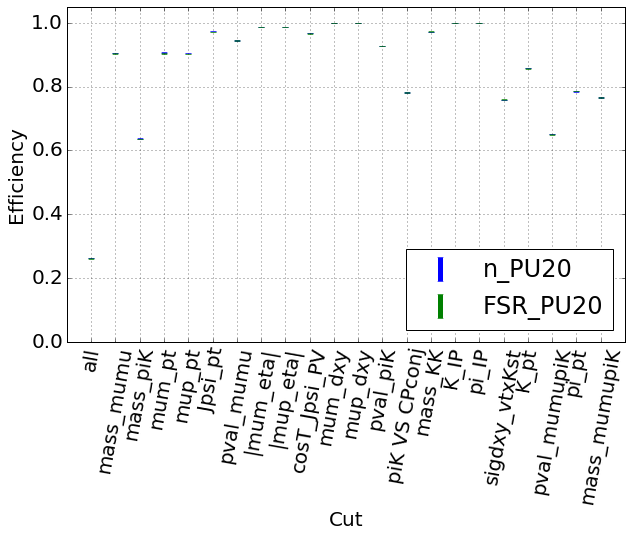

In [11]:
allCuts = ' && '.join(candidateSelection_stringList)
eff = {}
for n, t in T.iteritems():
    print n
    eff[n] = np.zeros((len(candidateSelection_stringList)+1,2))
    Ntot = float(t.GetEntries())
    Nsel = t.GetEntries(allCuts)
    eff[n][0] = getEff(Nsel, Ntot)
    pb = ProgressBar(maxEntry=len(candidateSelection_stringList))
    for ic, c in enumerate(candidateSelection_stringList):
        pb.show(ic)
        eff[n][ic+1] = getEff(t.GetEntries(c), Ntot)

for n in T.keys():
    y = np.array(eff[n])
    x = np.arange(y.shape[0])
    plt.errorbar(x, y[:, 0], y[:,1], lw=0, elinewidth=5, label=n)

plt.rcParams.update({'font.size': 20})
plt.xlabel('Cut')
plt.ylabel('Efficiency')
plt.legend(loc='best', numpoints=1)
plt.xticks(range(len(candidateSelection_nameList)+1), ['all']+candidateSelection_nameList, rotation=80)
plt.ylim(0
         ,1.05)
plt.xlim(-1, len(candidateSelection_nameList)+1)
plt.grid()
plt.gcf().set_size_inches(10, 6)

n_PU20
n_PU20 0.00 +/- 0.00 %
n_PU20 0.00 +/- 0.00 %
n_PU20 26.27 +/- 0.09 %
FSR_PU20
FSR_PU20 0.00 +/- 0.00 %
FSR_PU20 0.00 +/- 0.00 %
FSR_PU20 26.15 +/- 0.10 %


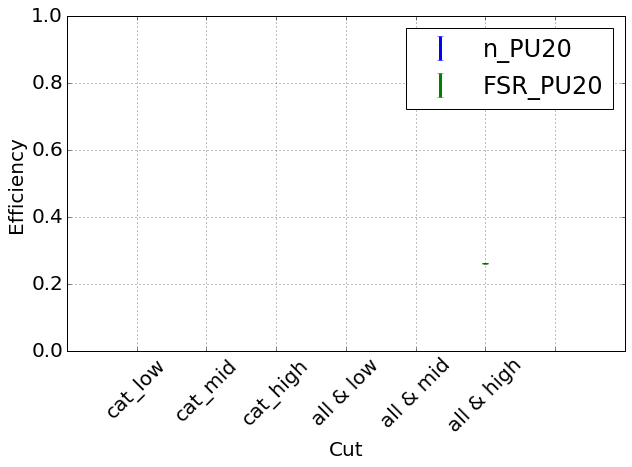

In [12]:
allCuts = ' && '.join(candidateSelection_stringList)
cat = ['cat_low', 'cat_mid', 'cat_high']
eff = {}
for n, t in T.iteritems():
    print n
    eff[n] = np.zeros((2*len(cat), 2))
    Ntot = float(t.GetEntries())
    Nsel = t.GetEntries(allCuts)
    eff[n][0] = getEff(Nsel, Ntot)
    for ic, c in enumerate(cat):
        eff[n][ic] = getEff(t.GetEntries(c), Ntot)
    for ic, c in enumerate(cat):
        eff[n][ic+len(cat)] = getEff(t.GetEntries(c + ' && ' + allCuts), Ntot)
        print n, '{:.2f} +/- {:.2f} %'.format(*(100*eff[n][ic+len(cat)]))

for n in T.keys():
    y = np.array(eff[n])
    x = np.arange(y.shape[0])
    plt.errorbar(x, y[:, 0], y[:,1], lw=0, elinewidth=3, label=n)

plt.rcParams.update({'font.size': 20})
plt.xlabel('Cut')
plt.ylabel('Efficiency')
plt.legend(loc='best', numpoints=1)
plt.xticks(range(2*len(cat)+1), cat+['all & '+c.replace('cat_', '') for c in cat], rotation=45)
plt.ylim(0.7*np.min([np.min(e[:,0]) for e in eff.values()]), plt.ylim()[1])
plt.xlim(-1,plt.xlim()[1]+1)
# plt.yscale('log')
plt.grid()
plt.gcf().set_size_inches(10, 6)